# 6.3 Нормализация и стандартизация данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy.stats import shapiro
import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [2]:
ds = pd.read_csv('Energy_and_Water_Data_Disclosure.csv') # https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml
print('Размер загруженного датасета: {}'.format(ds.shape))

Размер загруженного датасета: (11746, 60)


Для ускорения вычислений создадим подвыборку из 2000 случайных элементов из исходного датасета и продолжим работать только с ними:

In [3]:
n_rand = np.random.randint(0, len(ds), 2000) # выберем 2000 случайных элементов из датасета
ds = ds.iloc[n_rand]

Начнем как обычно с подготовки данных как было показано в разделе 6.1:

In [4]:
ds.head(3) # посмотрим на первые 3 строчки датасета

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
174,185,5070488,Chase,4092487,"Bay Plaza Community Center, LLC",2051410810,2-05141-0810,2000000,2130 Bartow Ave,Not Available,...,622.8,05/01/2017 04:42:29 PM,No,In Compliance,40.869429,-73.825737,10.0,12.0,46201.0,Co-op City ...
1349,1631,2653174,235 West 22nd (W57),Not Applicable: Standalone Property,Not Applicable: Standalone Property,1007720018,1007720018,1014111,235 WEST 22 STREET,Not Available,...,108.6,03/28/2017 10:04:17 AM,Yes,In Compliance,40.743907,-73.997239,4.0,3.0,91.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
8022,9901,4409023,53 Hope St. LLC,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3023690040,3-02369-0040,3062518,55 Hope St,Not Available,...,117.9,04/28/2017 02:30:13 PM,No,In Compliance,40.713193,-73.955801,1.0,34.0,519.0,North Side-South Side ...


In [5]:
ds = ds.drop(['Order', 'Property Id', 'Parent Property Id'], axis=1) #  выбросим признаки, т.к. это просто счетчики

В датасете много значений  "Not Available", заменим их на Nan:

In [6]:
ds = ds.replace('Not Available', np.nan)

In [7]:
ds.dtypes.value_counts() # кол-во признаков разных типов в датасете - 47 категориальных и 10 численных

object     46
float64     7
int64       4
dtype: int64

Кажется, что кол-во численных признаков должно быть больше, возможно они записаны как строковые переменные - проверим это:

In [8]:
for col in ds.columns: 
    if ds[col].dtype == 'O': # если колонка типа object
        try:
            ds[col] = ds[col].astype(float) # преобразуем в формат float
        except:
            pass

In [9]:
ds.dtypes.value_counts() # теперь кол-во категориальных равно 22, а числовых - 35

float64    31
object     22
int64       4
dtype: int64

Выбросим признаки, в которых отсутствуют больше 60 процентов данных:

In [10]:
missed_ratio = (ds.isna().sum()/len(ds)*100).sort_values(ascending=False) # процент пропущенных значений в каждом признаке
ds = ds.drop(missed_ratio[missed_ratio>60].index, axis=1)

Заполним пропуски в численных данных медианными значениями, а пропуски в категориальных данных - модальными:

In [11]:
num_columns = ds.select_dtypes(exclude='O').columns # численные признаки в датасете
cat_columns = ds.select_dtypes(include='O').columns # категориальные признаки в датасете

ds[num_columns] = ds[num_columns].fillna(ds[num_columns].median()) # заполним пропуски медианными значениями
ds[cat_columns] = ds[cat_columns].fillna(ds[cat_columns].mode(axis=0).iloc[0]) # заполним пропуски модальными значениями

In [12]:
print('Кол-во пропущенных значения в датасете: {}'.format(ds.isna().sum().sum()))

Кол-во пропущенных значения в датасете: 0


Многие алгоритмы машинного обучения построены на предположении о Гауссовом (нормальном) распределении входных данных. Поэтому для качественной работы таких моделей, обязательна проверка данных на нормальность, а при необходимости - приведение их к распределению, близкому к нормальному.

Кроме того, в данном датасете присутствуют численные признаки разных масштабов. Например, "DOF Gross Floor Area" по порядку ~10^5, а Site EUI (kBtu/ft²) по порядку ~10^2, поэтому необходимо отмасштабировать признаки.

In [13]:
ds_num = ds[num_columns] # рассматриваем только численные признаки

In [14]:
ds_num.head()

,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),...,Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
174,540388.0,3190.0,2004,1,100,3.0,279.0,295.1,45.2,1.4,...,46.7,3190,4429.8,44.14,622.8,40.869429,-73.825737,10.0,12.0,46201.0
1349,116586.0,96500.0,1974,1,100,93.0,60.2,82.5,5.4,0.5,...,194.3,96500,3977.1,41.21,108.6,40.743907,-73.997239,4.0,3.0,91.0
8022,120582.0,120582.0,1907,1,100,59.0,57.9,60.1,7.8,0.3,...,306.0,120582,3284.1,27.24,117.9,40.713193,-73.955801,1.0,34.0,519.0
7694,94596.0,101134.0,1930,1,100,65.0,67.2,71.4,3.6,0.6,...,122.3,103110,6037.9,58.56,97.2,40.667566,-73.961314,9.0,35.0,213.0
7391,422950.0,196856.0,2015,1,95,79.0,70.0,71.4,8.4,0.4,...,732.7,375327,4429.8,44.14,134.8,40.702601,-73.992134,2.0,33.0,21.0


Проверку на нормальность можно проводить несколькими способами:
- построение гистограммы признака
- построение QQ-графика
- проведение теста на нормальность

Рассмотрим каждый из подходов на одном из признаков из датасета, например, 'Site EUI (kBtu/ft²)'. Для приведения данных к нормальному виду используем преобразование Йео-Джонсона из метода PowerTransformer из библиотеки sklearn:

In [15]:
yeo = PowerTransformer(method='yeo-johnson', standardize=True)
ds_norm = pd.DataFrame(yeo.fit_transform(ds_num), columns=ds_num.columns) # нормализуем датасет
ds_norm.head()

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),...,Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
0,0.0,-5.053609,1.714519,-0.151893,0.264383,-1.988733,1.816726,1.941770,2.579458,1.828390,...,-1.008136,-5.077054,0.008320,0.084459,2.212021,1.795254,3.109449,0.879546,0.362441,2.069649
1,0.0,-0.131682,0.816695,-0.151893,0.264383,1.243768,-0.237009,0.126808,-0.121317,0.284054,...,-0.064511,-0.176043,-0.093463,0.008541,-0.182052,-0.242906,-0.870488,-0.863074,-1.136506,-0.698819
2,0.0,0.165187,-1.444090,-0.151893,0.264383,-0.100371,-0.290808,-0.334728,0.390162,-0.316504,...,0.250266,0.118460,-0.270631,-0.444631,-0.064297,-0.659290,0.094630,-2.075708,1.385576,0.525292
3,0.0,-0.068943,-0.627395,-0.151893,0.264383,0.129733,-0.085473,-0.083286,-0.687818,0.532783,...,-0.378530,-0.088150,0.309083,0.398807,-0.341757,-1.226585,-0.033642,0.622120,1.411940,-0.037429
4,0.0,0.808248,2.028217,-0.151893,-3.565916,0.679084,-0.029384,-0.083286,0.492031,0.003259,...,0.873652,1.573802,0.008320,0.084459,0.126630,-0.796276,-0.751469,-1.620708,1.358300,-2.184964


### Построение гистограммы

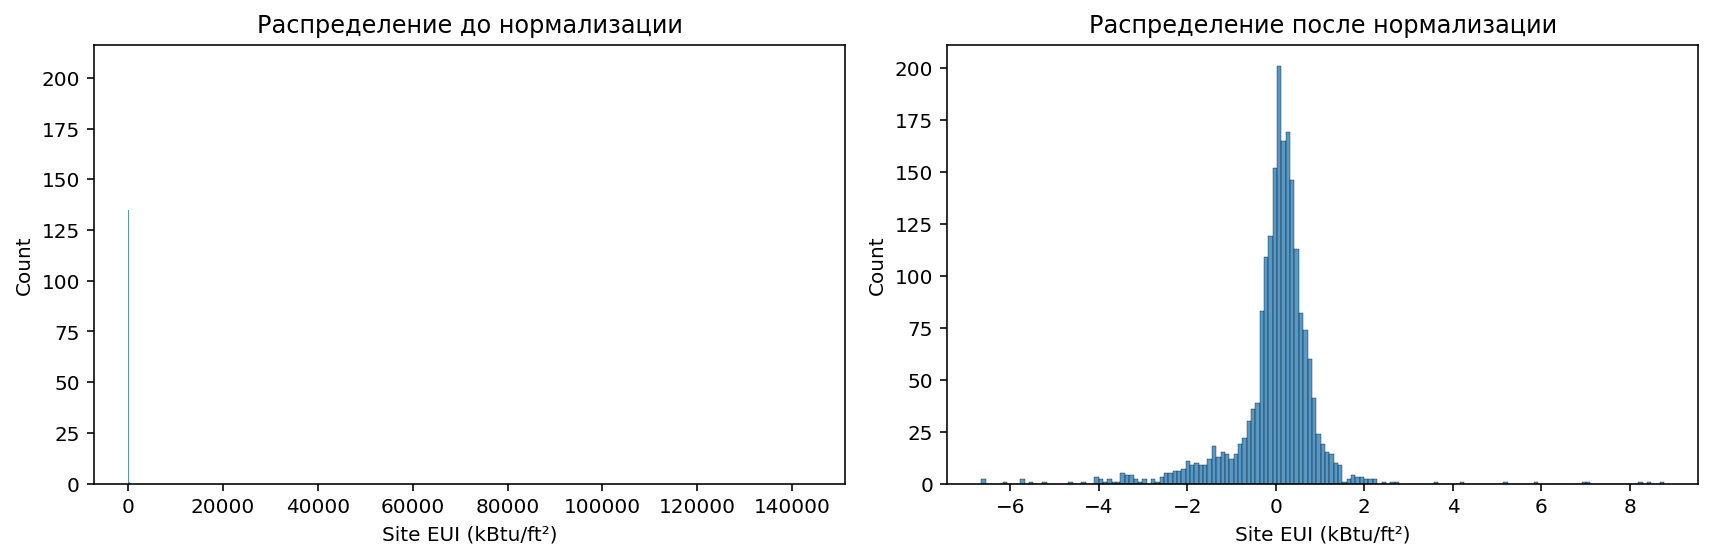

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.histplot(ds_num['Site EUI (kBtu/ft²)']).set_title('Распределение до нормализации')
plt.subplot(122)
sns.histplot(ds_norm['Site EUI (kBtu/ft²)']).set_title('Распределение после нормализации')
plt.tight_layout()

### Probability-график

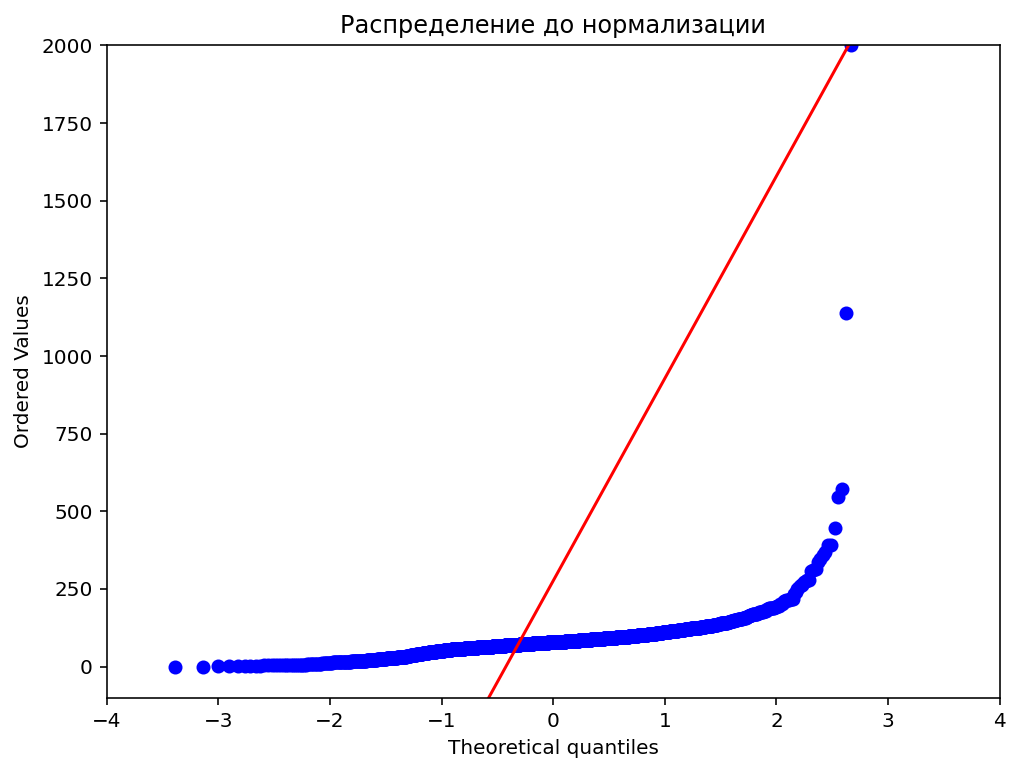

In [30]:
from scipy import stats

plt.figure(figsize=(8,6))
stats.probplot(ds_num['Site EUI (kBtu/ft²)'], dist='norm', plot=plt)
plt.title('Распределение до нормализации')
plt.axis([-4, 4, -100, 2000]);

Очевидно, что данные далеки от нормалного распределения, которое на данном графике представляет красная линия, также очевидны выбросы в данных, которые необходимо обработать и работа с которыми будет показана в части 6.5

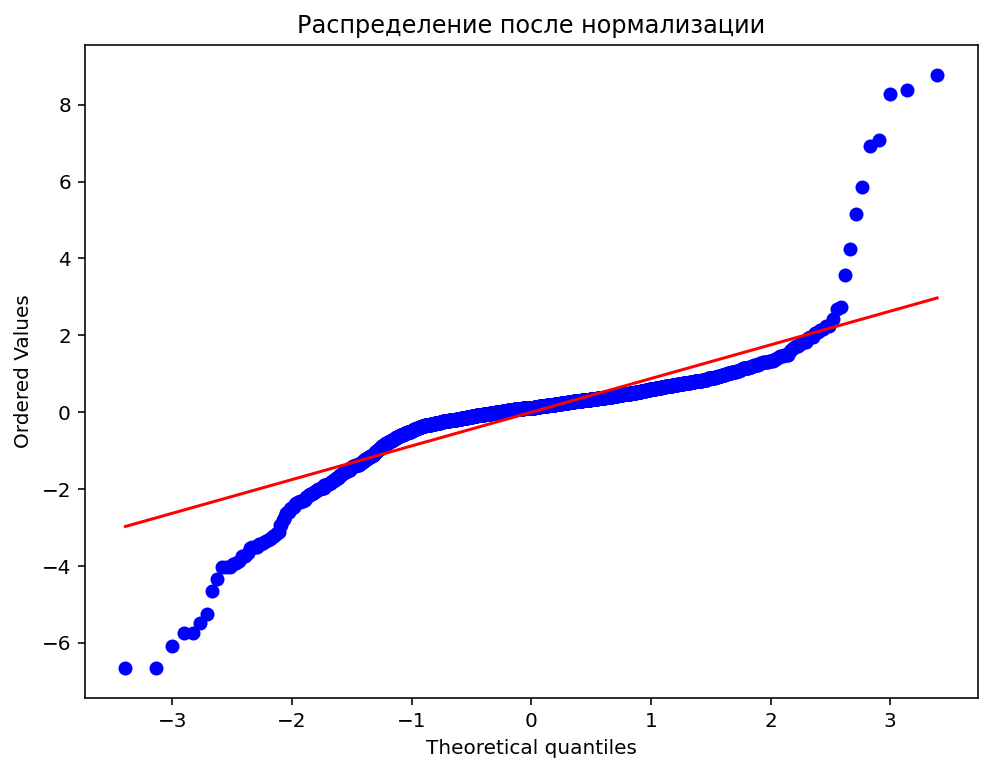

In [32]:
plt.figure(figsize=(8,6))
stats.probplot(ds_norm['Site EUI (kBtu/ft²)'], dist='norm', plot=plt)
plt.title('Распределение после нормализации');

После нормализации график уже ближе к нормальному распределению, хотя и по-прежнему с значительными отклонениями.

### Тест Шапиро-Уилка на нормальность

In [23]:
shapiro(ds_num['Site EUI (kBtu/ft²)'])

ShapiroResult(statistic=0.019986450672149658, pvalue=0.0)

In [24]:
shapiro(ds_norm['Site EUI (kBtu/ft²)'])

ShapiroResult(statistic=0.7792606949806213, pvalue=1.401298464324817e-45)

В данном случае нулевая гипотеза отвергается в обоих случаях (p-value < 0.05), что подразумевает, что в обоих случая распределения НЕ является нормальными. Однако, проверка нормальности статистическими тестами является очень строгой, т.к. идет сравнение с идеальным распределением. Поэтому, несмотря на то, что статистический тест говорит о ненормальности распределения, всегда стоит смотреть на гистограмму распределения.

### Стандартизация и масштабирование

При нормализации данных в методе PowerTransformer был задан параметр стандартизации (standartize=True), который привел распределение к стандартному (вычитание среднего и масштабирование дисперсией). Однако можно было бы использовать другие подходы для масштабирования и стандартизации:

In [25]:
# масштабирование признака, что все значения находится в определенном интервале, по умолчанию - (0,1)
scl = MinMaxScaler()
pd.DataFrame(scl.fit_transform(ds_num['Site EUI (kBtu/ft²)'].values.reshape(-1,1))).describe()

,0
count,2000.000000
mean,0.001625
std,0.026588
min,0.000000
25%,0.000432
50%,0.000550
75%,0.000688
max,1.000000


In [26]:
# стандартизация признака (вычитание среднего и масштабирование дисперсией)
scl = StandardScaler()
pd.DataFrame(scl.fit_transform(ds_num['Site EUI (kBtu/ft²)'].values.reshape(-1,1))).describe()

,0
count,2.000000e+03
mean,1.243450e-17
std,1.000250e+00
min,-6.113237e-02
25%,-4.487943e-02
50%,-4.043731e-02
75%,-3.526354e-02
max,3.755956e+01


In [27]:
# стандартизация признака, однако преобразование происходит с помощью персантилей, тем самым снижается эффект выбросов
scl = RobustScaler() 
pd.DataFrame(scl.fit_transform(ds_num['Site EUI (kBtu/ft²)'].values.reshape(-1,1))).describe()

,0
count,2000.000000
mean,4.205261
std,104.020589
min,-2.152174
25%,-0.461957
50%,0.000000
75%,0.538043
max,3910.195652
